# Setup environment

In Google Colab we need to roll back to the previous runtime 2025.07 - [see here](https://research.google.com/colaboratory/runtime-version-faq.html).

Click "Runtime" → "Change runtime type" → "Runtime version" → "2025.07"

Now we install some necessary libraries, including:
- downgrade `tensorflow` to 2.14.0, the last version compatible with QKeras
- `qkeras` - the quantization aware training library
- `hls4ml` - the NN to FPGA library

In [2]:
!pip install tensorflow==2.14.0 qkeras hls4ml

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 107.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 125.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
%%bash

git clone https://github.com/thesps/hls4ml-tutorial.git -b uzh2025
mv hls4ml-tutorial/* .
rm -r hls4ml-tutorial

Cloning into 'hls4ml-tutorial'...
Updating files: 100% (671/671), done.


# Part 1: Quantizers

In [3]:
from qkeras.quantizers import quantized_bits, quantized_relu
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# set the random seed for reproducibility
seed = 'uzh2025'
seed = int.from_bytes(seed.encode('utf-8')) % 2**32
np.random.seed(seed)

## Quantize

Let's first of all see what QKeras quantizers do by simply quantizing some values and plotting them. We first of all create a quantizer with 8 bits width and 4 bits integer (not including sign, in QKeras) with `q = quantized_bits(8,4)` and apply it to quantized the values in an array with `q(x)`.

Try adding some more lines with different quantization applied. We created a uniformly sampled array of `x` - make sure that the spacing of `x` is more fine than the quantization you then use.

In [4]:
help(quantized_bits)

Help on class quantized_bits in module qkeras.quantizers:

class quantized_bits(BaseQuantizer)
 |  quantized_bits(bits=8, integer=0, symmetric=0, keep_negative=True, alpha=None, use_stochastic_rounding=False, scale_axis=None, qnoise_factor=1.0, var_name=None, use_ste=True, use_variables=False)
 |  
 |  Quantizes the number to a number of bits.
 |  
 |  In general, we want to use a quantization function like:
 |  
 |  a = (pow(2,bits) - 1 - 0) / (max(x) - min(x))
 |  b = -min(x) * a
 |  
 |  in the equation:
 |  
 |  xq = a x + b
 |  
 |  This requires multiplication, which is undesirable. So, we
 |  enforce weights to be between -1 and 1 (max(x) = 1 and min(x) = -1),
 |  and separating the sign from the rest of the number as we make this function
 |  symmetric, thus resulting in the following approximation.
 |  
 |  1) max(x) = +1, min(x) = -1
 |  2) max(x) = -min(x)
 |  
 |  a = pow(2,bits-1)
 |  b = 0
 |  
 |  Finally, just remember that to represent the number with sign, the
 |  lar

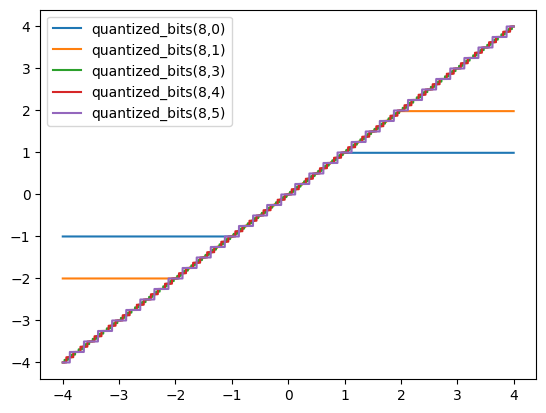

In [7]:
x = np.linspace(-4,4,4000)
q = quantized_bits(8,0)
r = quantized_bits(8,1)
s = quantized_bits(8,3)
t = quantized_bits(8,4)
u = quantized_bits(8,5)

x_quant_84 = q(x)
w_quant_84 = r(x)
z_quant_84 = s(x)
y_quant_84 = t(x)
b_quant_84 = u(x)


plt.plot(x, x_quant_84, label='quantized_bits(8,0)')
plt.legend()
plt.plot(x, w_quant_84, label='quantized_bits(8,1)')
plt.legend()
plt.plot(x, z_quant_84, label='quantized_bits(8,3)')
plt.legend()
plt.plot(x, y_quant_84, label='quantized_bits(8,4)')
plt.legend()
plt.plot(x, b_quant_84, label='quantized_bits(8,5)')
plt.legend()

In [10]:
print(f'First 10 samples of x:\n{x[:10]}')
print(f'First 10 samples of q(x):\n{x_quant_84[:10]}')

First 10 samples of x:
[-4.        -3.9979995 -3.995999  -3.9939985 -3.991998  -3.9899975
 -3.987997  -3.9859965 -3.983996  -3.9819955]
First 10 samples of q(x):
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


## Exercise - bit growth (sum)

Now we want to test the ideas in the lecture in practice, by choosing the right number of bits for the result of some operations, starting with summation.

Create a batch of vectors of random floating point number in a range, with 8 elements per vector.

In [11]:
a = np.random.uniform(-16, 16, 1024).reshape(-1, 8)
b = np.random.uniform(-16, 16, 1024).reshape(-1, 8)

In [12]:
print(f'Shape of a, shape of b: {a.shape}, {b.shape}')
print(f'First 3 samples of a:\n{a[:3]}')
print(f'First 3 samples of b:\n{b[:3]}')

Shape of a, shape of b: (128, 8), (128, 8)
First 3 samples of a:
[[-10.51059904  -9.37055411   3.08377872  11.29225425   7.76849976
   -3.15968667  -1.75330912  14.93508634]
 [ 15.72840086   7.20569689 -13.36412856  -1.27035315   2.37630932
  -11.92429693   2.164153    10.3545776 ]
 [  1.84651768  12.20920375   5.79288686 -14.2746262    0.65588212
   10.92745605   7.41875887  10.97178638]]
First 3 samples of b:
[[-9.29121411e-03 -1.36403190e+01 -2.11219936e-01 -6.74035908e+00
  -3.46878698e-01 -2.87967689e+00  1.07045414e+01 -1.59795553e+01]
 [ 1.17120843e+01 -5.09047133e+00  4.15134548e+00  1.71645195e+00
   6.71156568e+00 -1.87522364e+00  5.11291513e+00  1.16785312e+00]
 [ 3.14732796e+00 -9.53965648e-01 -6.23783343e+00  1.29307723e+01
  -1.59235524e+01  1.03219037e+01  4.01384873e+00 -1.31065997e+01]]


## Quantize

We will first quantize the random numbers

In [13]:
q_i = quantized_bits(8,4) # quantizer for the inputs to the sum
a_quant = q_i(a)
b_quant = q_i(b)

In [14]:
print(f'Shape of a_quant, shape of b_quant: {a_quant.shape}, {b_quant.shape}')
print(f'First 3 samples of a_quant:\n{a_quant[:3]}')
print(f'First 3 samples of b_quant:\n{b_quant[:3]}')

Shape of a_quant, shape of b_quant: (128, 8), (128, 8)
First 3 samples of a_quant:
[[-10.5    -9.375   3.125  11.25    7.75   -3.125  -1.75   14.875]
 [ 15.75    7.25  -13.375  -1.25    2.375 -11.875   2.125  10.375]
 [  1.875  12.25    5.75  -14.25    0.625  10.875   7.375  11.   ]]
First 3 samples of b_quant:
[[  0.    -13.625  -0.25   -6.75   -0.375  -2.875  10.75  -16.   ]
 [ 11.75   -5.125   4.125   1.75    6.75   -1.875   5.125   1.125]
 [  3.125  -1.     -6.25   12.875 -15.875  10.375   4.    -13.125]]


### Sum

Now we take the sum of the quantized vectors `c = a_quant + b_quant`. We then quantize that result with a new quantizer `c_quant = q_o_sum(c)`. Your task will be to define the quantization of the sum result such that `q_o_sum(c) == c`.

In [15]:
# TODO: change the bits here
q_o_sum = quantized_bits(9,5) # quantizer for the output of the sum, +1 for integer part, but also for total length
c = a_quant + b_quant
c_quant = q_o_sum(c) # quantize the result

In [16]:
print(f'Shape of c, shape of c_quant: {c.shape}, {c_quant.shape}')
print(f'First 3 samples of c:\n{c[:3]}')
print(f'First 3 samples of c_quant:\n{c_quant[:3]}')

Shape of c, shape of c_quant: (128, 8), (128, 8)
First 3 samples of c:
[[-10.5   -23.      2.875   4.5     7.375  -6.      9.     -1.125]
 [ 27.5     2.125  -9.25    0.5     9.125 -13.75    7.25   11.5  ]
 [  5.     11.25   -0.5    -1.375 -15.25   21.25   11.375  -2.125]]
First 3 samples of c_quant:
[[-10.5   -23.      2.875   4.5     7.375  -6.      9.     -1.125]
 [ 27.5     2.125  -9.25    0.5     9.125 -13.75    7.25   11.5  ]
 [  5.     11.25   -0.5    -1.375 -15.25   21.25   11.375  -2.125]]


### Task

Use the right number of bits for `q_o_sum` such that the test below passes, finding the _smallest valid values_ for the width and number of integer bits.

In [17]:
np.testing.assert_array_equal(c, c_quant)

## Inspect

Visualize the differences below by plotting a histogram of the difference between `c` and `q(c)`. If we chose the right number of bits, the difference should be 0.

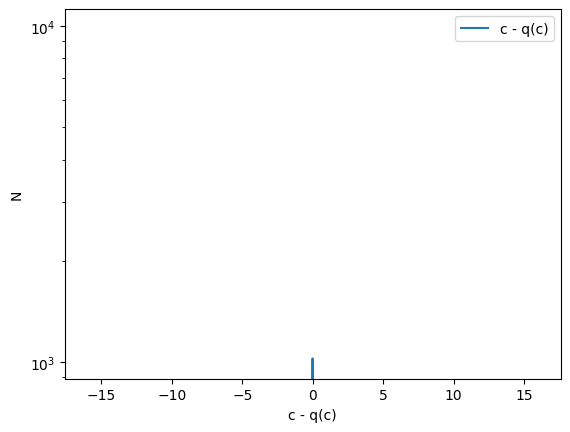

In [18]:
bins = np.linspace(-16,16,4000)
h, _ = np.histogram(c - c_quant, bins=bins)
plt.step(bins[:-1], h, label='c - q(c)')
plt.xlabel('c - q(c)')
plt.ylabel('N')
plt.semilogy()
plt.legend()

## Exercise - bit growth (dot product)

Now we'll do a similar exercise, using the same batch of dimension 8 vectors, taking the dot product between the samples in `a` and those in `b`. Note we're not taking the dot product between the `(128,8)` arrays, but between the samples `(1,8) · (8,1)`, so we'll have 128 values.

You need to choose the right quantizer for the result of the dot product such that the `d` and `d_quant` are equal. Use the rules you've learned for bitgrowth of multiplication and addition.

In [19]:
# TODO: change the bits here
q_o_dot = quantized_bits(19,11) # quantizer for the output of the dot product
d = np.sum(a_quant * b_quant, axis=-1) # take the dot between pairs of vectors
d_quant = q_o_dot(d) # quantize the result

In [20]:
print(f'Shape of d, shape of d_quant: {d.shape}, {d_quant.shape}')
print(f'First 10 samples of d:\n{d[:10]}')
print(f'First 10 samples of d_quant:\n{d_quant[:10]}')

Shape of d, shape of d_quant: (128,), (128,)
First 10 samples of d:
[-199.71875   151.40625  -237.76562  -319.79688   193.46875   -79.515625
 -137.95312  -255.34375  -166.40625    71.875   ]
First 10 samples of d_quant:
[-199.71875   151.40625  -237.76562  -319.79688   193.46875   -79.515625
 -137.95312  -255.34375  -166.40625    71.875   ]


In [22]:
np.testing.assert_array_equal(d, d_quant)

## Inspect

Visualize the differences below by plotting a histogram of the difference between `d` and `q(d)`. If we chose the right number of bits, the difference should be 0.

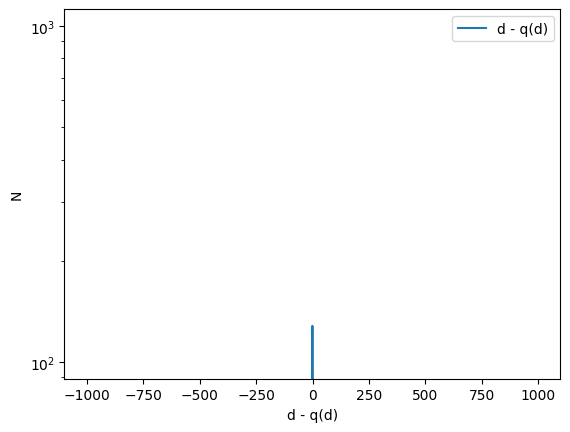

In [23]:
bins = np.linspace(-1000,1000,4000)
h, _ = np.histogram(d - d_quant, bins=bins)
plt.step(bins[:-1], h, label='d - q(d)')
plt.xlabel('d - q(d)')
plt.ylabel('N')
plt.semilogy()
plt.legend()

# Part 2: Quantization Aware Training

## Import libraries

In [24]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import tensorflow as tf

tf.random.set_seed(seed)

## Fetch the jet tagging dataset from Open ML

**Note**: this takes about a minute to download the dataset

In [25]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']

### Let's print some information about the dataset
Print the feature names and the dataset shape

In [26]:
print(f"Feature names: {data['feature_names']}\n")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}\n")
print(f"First 10 samples, X:\n {X[:10]}\n")
print(f"First 10 samples, y:\n {y[:10]}\n")

Feature names: ['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']

X shape: (830000, 16)
y shape: (830000,)

First 10 samples, X:
       zlogz  c1_b0_mmdt  c1_b1_mmdt  c1_b2_mmdt  c2_b1_mmdt  c2_b2_mmdt  \
0 -2.935125    0.383155    0.005126    0.000084    0.009070    0.000179   
1 -1.927335    0.270699    0.001585    0.000011    0.003232    0.000029   
2 -3.112147    0.458171    0.097914    0.028588    0.124278    0.038487   
3 -2.666515    0.437068    0.049122    0.007978    0.047477    0.004802   
4 -2.484843    0.428981    0.041786    0.006110    0.023066    0.001123   
5 -2.513208    0.432403    0.033556    0.005395    0.034329    0.002248   
6 -2.985767    0.461152    0.067243    0.016601    0.027135    0.001565   
7 -2.961123    0.446868    0.008109    0.000198    0.011185    0.000253   
8 -1.865473    0.3

As you saw above, the `y` target is an array of strings of the jet flavour, e.g. \['g', 'w',...\] etc.
We need to make this a "One Hot" encoding for the training.
Then, split the dataset into training and validation sets

In [27]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y[:5])

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


In [28]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

Save the preprocessed and train-test-split arrays to files so that we can skip the steps above next time.

In [29]:
np.save('X_train_val.npy', X_train_val)
np.save('X_test.npy', X_test)
np.save('y_train_val.npy', y_train_val)
np.save('y_test.npy', y_test)
np.save('classes.npy', le.classes_)

## Now construct a model
We'll use 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

In [31]:
model = Sequential()
model.add(Dense(64, input_shape=(16,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(5, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

## Train the model
We'll use Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_1'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model.

In [32]:
train = True
if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='model_1',
    )
    model.fit(
        X_train_val,
        y_train_val,
        batch_size=1024,
        epochs=30,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
else:
    from tensorflow.keras.models import load_model

    model = load_model('model_1/KERAS_check_best_model.h5')

Epoch 1/30
481/487 [============================>.] - ETA: 0s - loss: 0.9623 - accuracy: 0.6840
***callbacks***
saving losses to model_1/losses.log

Epoch 1: val_loss improved from inf to 0.83053, saving model to model_1/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 0.83053, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 1: saving model to model_1/KERAS_check_model_last.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 1: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 6s 9ms/step - loss: 0.9606 - accuracy: 0.6846 - val_loss: 0.8305 - val_accuracy: 0.7312 - lr: 0.0010
Epoch 2/30
483/487 [============================>.] - ETA: 0s - loss: 0.8001 - accuracy: 0.7393
***callbacks***
saving losses to model_1/losses.log

Epoch 2: val_loss improved from 0.83053 to 0.78564, saving model to model_1/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 0.83053 to 0.78564, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 2: saving model to model_1/KERAS_check_model_last.h5

Epoch 2: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 5s 11ms/step - loss: 0.8000 - accuracy: 0.7393 - val_loss: 0.7856 - val_accuracy: 0.7438 - lr: 0.0010
Epoch 3/30
486/487 [============================>.] - ETA: 0s - loss: 0.7699 - accuracy: 0.7483
***callbacks*

## Check performance
Check the accuracy and make a ROC curve

5188/5188 [==============================] - 11s 2ms/step
Accuracy: 0.7630903614457831


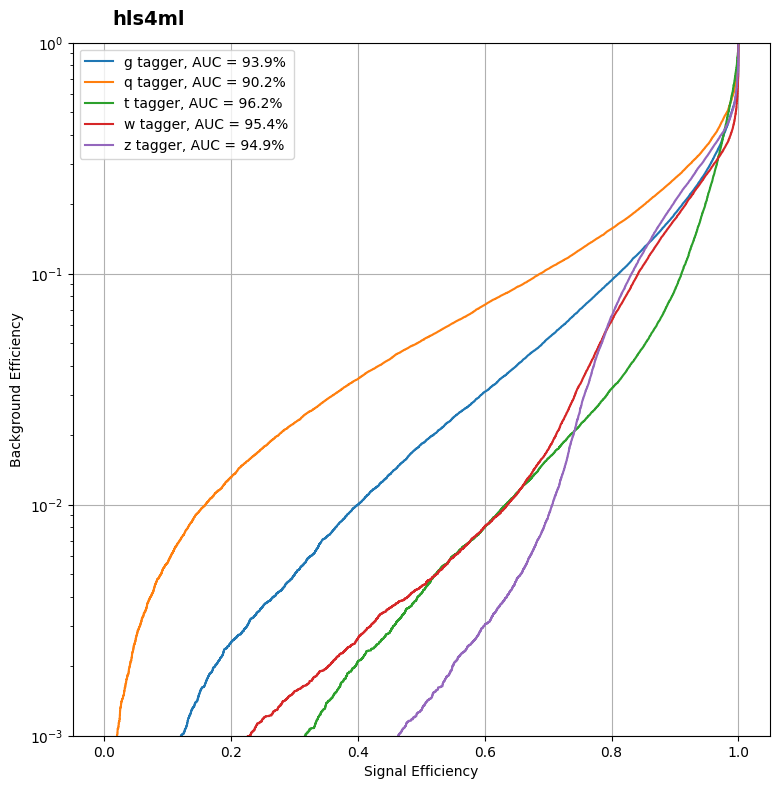

In [33]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

y_keras = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
plt.figure(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, le.classes_)

# Quantization Aware Training

Now we train a new model using Quantization Aware Training via `QKeras`.

We replace layers like `Dense` and `Activation` with `QDense` and `QActivation`, and specifiy quantizers to use for the weights, biases and activations.

Notice that the model is still a `Keras` model, and the last layer is a regular `Keras` `Softmax` layer. In general you can mix-and-match normal `Keras` layers with `QKeras` ones.

In [34]:
from qkeras.qlayers import QDense, QActivation

In [35]:
qmodel = Sequential()
qmodel.add(
    QDense(
        64,
        input_shape=(16,),
        name='fc1',
        kernel_quantizer=quantized_bits(8, 0, alpha=1),
        bias_quantizer=quantized_bits(8, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
qmodel.add(QActivation(activation=quantized_relu(8), name='relu1'))
qmodel.add(
    QDense(
        32,
        name='fc2',
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
qmodel.add(QActivation(activation=quantized_relu(6), name='relu2'))
qmodel.add(
    QDense(
        32,
        name='fc3',
        kernel_quantizer=quantized_bits(4, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
qmodel.add(QActivation(activation=quantized_relu(4), name='relu3'))
qmodel.add(
    QDense(
        5,
        name='output',
        kernel_quantizer=quantized_bits(8, 0, alpha=1),
        bias_quantizer=quantized_bits(8, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
qmodel.add(Activation(activation='softmax', name='softmax'))

In [36]:
train = True
if train:
    adam = Adam(lr=0.0001)
    qmodel.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='qmodel_1',
    )
    qmodel.fit(
        X_train_val,
        y_train_val,
        batch_size=1024,
        epochs=30,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
    qmodel.save('qmodel_1/KERAS_check_best_model.h5')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects

    co = {}
    _add_supported_quantized_objects(co)
    qmodel = load_model('qmodel_1/KERAS_check_best_model.h5', custom_objects=co)

/usr/local/lib/python3.11/dist-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


Epoch 1/30
485/487 [============================>.] - ETA: 0s - loss: 0.9551 - accuracy: 0.6970
***callbacks***
saving losses to qmodel_1/losses.log

Epoch 1: val_loss improved from inf to 0.80596, saving model to qmodel_1/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 0.80596, saving model to qmodel_1/KERAS_check_best_model_weights.h5

Epoch 1: saving model to qmodel_1/KERAS_check_model_last.h5

Epoch 1: saving model to qmodel_1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 9s 13ms/step - loss: 0.9546 - accuracy: 0.6971 - val_loss: 0.8060 - val_accuracy: 0.7391 - lr: 0.0010
Epoch 2/30
  8/487 [..............................] - ETA: 3s - loss: 0.7915 - accuracy: 0.7467

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


486/487 [============================>.] - ETA: 0s - loss: 0.7803 - accuracy: 0.7463
***callbacks***
saving losses to qmodel_1/losses.log

Epoch 2: val_loss improved from 0.80596 to 0.77120, saving model to qmodel_1/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 0.80596 to 0.77120, saving model to qmodel_1/KERAS_check_best_model_weights.h5

Epoch 2: saving model to qmodel_1/KERAS_check_model_last.h5

Epoch 2: saving model to qmodel_1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 5s 10ms/step - loss: 0.7803 - accuracy: 0.7463 - val_loss: 0.7712 - val_accuracy: 0.7489 - lr: 0.0010
Epoch 3/30
487/487 [==============================] - ETA: 0s - loss: 0.7552 - accuracy: 0.7524
***callbacks***
saving losses to qmodel_1/losses.log

Epoch 3: val_loss improved from 0.77120 to 0.75301, saving model to qmodel_1/KERAS_check_best_model.h5

Epoch 3: val_loss improved from 0.77120 to 0.75301, saving model to qmodel_1/KERAS_check_best_m

## Compare

Plot the ROC curve of the QKeras model alongside the Keras model we trained earlier, and print the accuracy of both. If we chose appropriate quantization, they should perform quite similarly 🤞

5188/5188 [==============================] - 25s 5ms/step
Accuracy Keras:  0.7630903614457831
Accuracy QKeras: 0.763421686746988


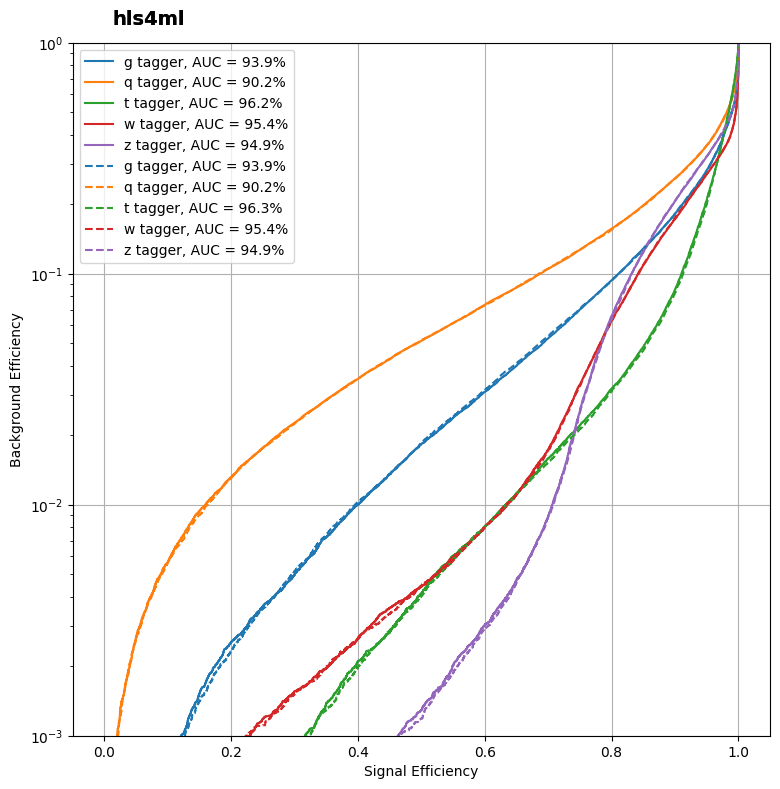

In [37]:
y_qkeras = qmodel.predict(X_test)

print("Accuracy Keras:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("Accuracy QKeras: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))

plt.figure(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, le.classes_)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_qkeras, le.classes_, linestyle='--')

## Exercise

Try changing the quantization of the weights, biases, and activations and retrain the QKeras model above. See how much you can reduce the bitwidths while maintaining an accuracy above 75%.

# Convert to FPGA code using `hls4ml`

Now we use `hls4ml` to transpile our trained Neural Network model into High Level Synthesis code that can by synthesized for FPGA. We first of all produce a configuration that details all of the settings to use in the FPGA code generation, including quantization and other parameters. When using QKeras, the quantization settings can be extracted from the `qmodel` that we provide.

After producing and editing the configuration, we `convert` the model into an `hls4ml` model object. This captures all of the parameters of the neural network, and provides an interface to produce FPGA code products for the model. We start by writing the project files, which you will find under `qmodel_q/hls4ml_prj`. This includes the C++ (HLS) description of the model we provided, including the architecture, its weights and bias values, the quantization settings, and the optimized inference functions.

In [38]:
import hls4ml

In [39]:
config = hls4ml.utils.config_from_keras_model(qmodel, granularity='name', backend='Vitis', default_precision='fixed<16,7>')
config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'
config['LayerName']['softmax']['Implementation'] = 'latency'
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    qmodel, hls_config=config, backend='Vitis', output_dir='qmodel_1/hls4ml_prj', part='xcu250-figd2104-2L-e'
)
hls_model.write()

-----------------------------------
Model
  Precision
    default:         fixed<16,7>
  ReuseFactor:       1
  Strategy:          Latency
  BramFactor:        1000000000
  TraceOutput:       False
LayerName
  fc1_input
    Trace:           False
    Precision
      result:        auto
  fc1
    Trace:           False
    Precision
      result:        auto
      weight:        fixed<8,1,TRN,WRAP,0>
      bias:          fixed<8,1,TRN,WRAP,0>
      accum:         auto
    ReuseFactor:     1
  fc1_linear
    Trace:           False
    Precision
      result:        auto
      table:         fixed<18,8,TRN,WRAP,0>
    ReuseFactor:     1
    TableSize:       1024
  relu1
    Trace:           False
    Precision
      result:        ufixed<8,0,RND_CONV,SAT,0>
      table:         fixed<18,8,TRN,WRAP,0>
    ReuseFactor:     1
    TableSize:       1024
  fc2
    Trace:           False
    Precision
      result:        auto
      weight:        fixed<6,1,TRN,WRAP,0>
      bias:          fixed

/usr/local/lib/python3.11/dist-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


## Validate

The FPGA design flow is time consuming, and working with FPGA hardware is not trivial. It's always good practice to check on our CPU that the FPGA design is correct before we go further. Since our Neural Network has been converted to C++ code (HLS), we can compile and run it on the CPU as well. `hls4ml` provides bindings and scripts to compile the C++ code and interact with it from Python. Here we compile the code and make an inference (on CPU) on our `X_test` data. This emulation produces bit-accurate results to what we would see on the FPGA device, given the same inputs.

In [40]:
hls_model.compile()
y_hls4ml = hls_model.predict(np.ascontiguousarray(X_test))

## Compare

Let's again produce the ROC curve, now with the original Keras model, the quantized QKeras model, and the hls4ml emulation of the QKeras model.

Accuracy Keras:  0.7630903614457831
Accuracy QKeras: 0.763421686746988
Accuracy hls4ml: 0.763289156626506


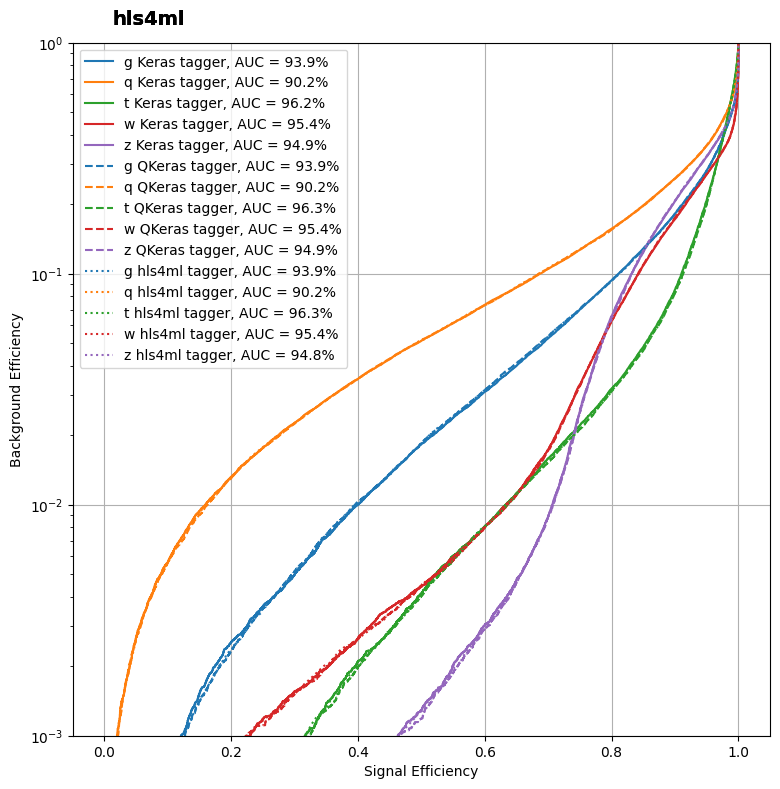

In [41]:
print("Accuracy Keras:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("Accuracy QKeras: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls4ml, axis=1))))


plt.figure(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, [c + ' Keras' for c in le.classes_])
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_qkeras, [c + ' QKeras' for c in le.classes_], linestyle='--')
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls4ml, [c + ' hls4ml' for c in le.classes_], linestyle=':')

# Synthesize

Everything we've done so far has taken place on the CPU. In order to go further with the FPGA we need to _synthesize_ the HLS C++ code into a lower level: _Harwdare Description Language_. This process uses software from the FPGA vendor, in this case AMD Xilinx, called `Vitis HLS`.

This might not be available in the environment you're using, so if it's available then the cell below will run this step, otherwise this step will pick up a report that's provided. The report output summarises estimates of the latency and resource usage of the neural network. Look at the absolute inference latency, and the percentage total resource usage of each resource type.

This report is a so called "Out of Context" report - meaning that the Neural Network is not interfaced to any other component. In a real system the Neural Network needs to be connected to the outside world somehow to receive its inputs and do something with its outputs. In Level 1 Trigger hardware, this can be achieved with extremely low latency and high throughput, but in other edge hardware that might not be the case. This ultra low latency inference can only be obtained with a correspondingly high performance I/O.

In [42]:
import shutil
if shutil.which('vitis_hls') is not None:
    # Vitis HLS is available, run csynthesis
    hls_model.build()
    qreport = 'qmodel_1/hls4ml_prj'
else:
    # use an already made report
    qreport = 'reports/qmodel_1/hls4ml_prj'

In [43]:
hls4ml.report.read_vivado_report(qreport)

Found 1 solution(s) in reports/qmodel_1/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Mon Nov 10 15:41:43 2025

* Version:        2024.1 (Build 5069499 on May 21 2024)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: virtexuplus
* Target device:  xcu250-figd2104-2L-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  |  5.00 ns|  3.648 ns|     1.35 ns|
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+-----+-----+---------+
    |  Latency (cycles) |   Latency (absolute)  |  Interval | Pipeline|
    |   min   |   max   |    min    |    max    | min | max |   Type  |
    +---------+--

## Compare

We can also synthesize the first, non-quantized Keras model that we trained. We use a method called "Post Training Quantization" where the floating point weights, biases, and activations are mapped onto fixed point representations after the model is trained. This usually comes with some performace degradation if the bitwidths are not wide enough, so `hls4ml` defaults to using 16 bits for everything. Compare this reports to see how much more efficient Quantization Aware Training can be!

In [44]:
if shutil.which('vitis_hls') is not None:
    fconfig = hls4ml.utils.config_from_keras_model(model, granularity='model', backend='Vitis')
    print("-----------------------------------")
    print("Configuration")
    plotting.print_dict(fconfig)
    print("-----------------------------------")
    hls_fmodel = hls4ml.converters.convert_from_keras_model(
        model, hls_config=fconfig, backend='Vitis', output_dir='model_1/hls4ml_prj', part='xcu250-figd2104-2L-e'
    )
    hls_fmodel.build()
    freport = 'model_1/hls4ml_prj'
else:
    freport = 'reports/model_1/hls4ml_prj'

In [45]:
hls4ml.report.read_vivado_report(freport)

Found 1 solution(s) in reports/model_1/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Mon Nov 10 16:36:57 2025

* Version:        2024.1 (Build 5069499 on May 21 2024)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: virtexuplus
* Target device:  xcu250-figd2104-2L-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  |  5.00 ns|  3.636 ns|     1.35 ns|
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+-----+-----+---------+
    |  Latency (cycles) |   Latency (absolute)  |  Interval | Pipeline|
    |   min   |   max   |    min    |    max    | min | max |   Type  |
    +---------+---